# Import

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.font_manager as fm
from matplotlib import rc
import matplotlib
matplotlib.font_manager._rebuild()

plt.rc('font', family='Malgun Gothic')

In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression

from lightgbm import LGBMRegressor
from lightgbm import plot_importance 
from xgboost import XGBRegressor
from xgboost import plot_importance
import xgboost as xgb

# Data Import
1. iszero
2. nozero
3. nf (new feature)
---
- input featrue = 27
- 7일간 data를 하나의 instance화 한다면 -> input matrix 7 x 26 -> ouput matrix 7 x 1 (가격만 출력)
- 2148 row x 26 columns
- 다변량 시계열(multiivariate time series) 예측 system
- In our cousre DA, design for 단변량 시계열(univariate time series) prediction
- 2014.01.01~2020.12.31 data
- 건고추는 2014.01.22부터, 나머지는 대부분 2014.01.02부터

In [14]:
path = "./Dataset/"
price_tag = ['건고추가격', '대파가격', '마늘가격', '무가격', '배추가격']
crops_en = ['peppers', 'green_onion', 'garlic', 'radish', 'cabbage']

# is zero
isZero = pd.read_csv(path+"da_data.csv")

# no zero 
noZero = pd.read_csv(path+"da_data_nozero.csv")

# new features 
nf_peppers = pd.read_csv(path+"last건고추.csv")
nf_green_onion = pd.read_csv(path+"last대파.csv")
nf_garlic = pd.read_csv(path+"last마늘.csv")
nf_radish = pd.read_csv(path+"last무.csv")
nf_cabbage = pd.read_csv(path+"last배추.csv")

original_data_list = [nf_peppers, nf_green_onion, nf_garlic, nf_radish, nf_cabbage]

In [15]:
X_column_pepper = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '건고추거래량', '건고추생산량', '건고추저장이월량', '건고추수입량', '건고추수입금액',
       '건고추재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_pepper = ['건고추가격']

X_column_green_onion = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '대파거래량', '대파생산량', '대파저장이월량', '대파수입량', '대파수입금액',
       '대파재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_green_onion = ['대파가격']

X_column_garlic = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '마늘거래량', '마늘생산량', '마늘저장이월량', '마늘수입량', '마늘수입금액',
       '마늘재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_garlic = ['마늘가격']

X_column_radish = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '무거래량', '무생산량', '무저장이월량', '무수입량', '무수입금액',
       '무재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_radish = ['무가격']

X_column_cabbage = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '배추거래량', '배추생산량', '배추저장이월량', '배추수입량', '배추수입금액',
       '배추재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_cabbage = ['배추가격']

X_column_list = [X_column_pepper, X_column_green_onion, X_column_garlic, X_column_radish, X_column_cabbage]
y_column_list = [y_column_pepper, y_column_green_onion, y_column_garlic, y_column_radish, y_column_cabbage] # oh...is same thing with p-tag...

# 함수화

In [16]:
def outliers_iqr(data, name) :
  print('원본 데이터 수 : ', len(data))

  Q1, Q3 = np.percentile(data[name], [25, 75])
  IQR = Q3 - Q1
  lower_bound = Q1 - (IQR * 1.5)
  upper_bound = Q3 + (IQR * 1.5)
  outlier_index = data[name][ (data[name] < lower_bound) | (data[name] > upper_bound) ].index.tolist()

  # 가격열 이상치 1일전/후 데이터의 평균값으로 대체
  num1list = [1] * len(outlier_index)
  outlier_pre = [outlier_index[i] - num1list[i] for i in range(len(outlier_index))]
  outlier_post = [outlier_index[i] + num1list[i] for i in range(len(outlier_index))]
  print(outlier_pre, '\n', outlier_post)

  outlier_sum = [data.loc[outlier_pre, name].tolist()[i] + data.loc[outlier_post, name].tolist()[i] for i in range(len(outlier_index))]
  num2list = [2] * len(outlier_index)
  outlier_result = [outlier_sum[i] / num2list[i] for i in range(len(outlier_index))]
  # print(data.loc[outlier_pre, name].tolist())
  # print(data.loc[outlier_post, name].tolist())
  # print(outlier_result)
  data.loc[outlier_index, name] = outlier_result
  print(data)
  return data

def pre_processing(data) :
    scaler = MinMaxScaler()
    scale_cols = data.iloc[:,2:].columns
    
    data.sort_index(ascending=False).reset_index(drop=True)
    
    scaled = scaler.fit_transform(data[scale_cols])
    scaled = pd.DataFrame(scaled)
    scaled.columns = scale_cols
    
    return scaled


def get_data_split(data, X_column, y_column) :
    train_X, test_X, train_y, test_y = train_test_split(
    data[X_column], 
    data[y_column],
    test_size=0.2,
    shuffle=True,   # random split 
    random_state=42) # seed 고정, same sampling 
    print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)
    
    return train_X, test_X, train_y, test_y


def get_model_cv_prediction(model, X_data, y_label) :
    neg_mse_scores = cross_val_score(model, X_data, y_label, scoring="neg_mean_squared_error", cv=5)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('####', model.__class__.__name__, '####')
    print('5 교차 검증의 평균 RMSE : {0:.3f}'.format(avg_rmse))


def gridsearchCV (model, parameters, X_train, y_train) :
    grid = GridSearchCV(model, param_grid = parameters, scoring='accuracy', cv=2) # cv is fold num
    grid.fit(X_train, y_train)
    
    print('GridSearchCV 최적 하이퍼 파라미터 :', grid.best_params_)
    print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid.best_score_))
    print('GridSearchCV 최적 하이퍼 파라미터로 학습된 Esimator 반환')
    
    return grid.best_estimator_

In [67]:
def show_pred(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    
    df_result = pd.DataFrame(list(zip(true_y, pred)), columns=['true_y', 'prediction'])
    return df_result

def show_mse_rmse(test_y, pred) :
    mse = mean_squared_error(test_y, pred)
    print("mse : %f" % mse)
    
    rmse = np.sqrt(mse)
    print("rmse: %f \n" %rmse)
    
def show_prediction_error(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    error = pred - true_y
    plt.hist(error, bins=50)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")


def feature_importance(model_xgb) : 
    %matplotlib inline
    plt.rcParams['axes.unicode_minus'] = False
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = fm.FontProperties(fname=font_path).get_name()
    rc('font', family=font)

    fig, ax = plt.subplots(figsize=(10,12))
    plot_importance(model_xgb, ax=ax)


def graph(pred, test_label) :
    plt.figure(figsize=(16, 9))
    plt.plot(test_label, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

# Preproecssing 

input_data_list -> 0:건고추, 1:대파, 2:마늘, 3:무, 4:배추

In [17]:
input_data_list = []
for data, tag in zip(original_data_list, price_tag) : 
    out_lier = outliers_iqr(data, tag)
    processed = pre_processing(out_lier)
    input_data_list.append(processed)

원본 데이터 수 :  2211
[1038, 1039, 1040, 1048, 1053, 1061, 1062, 1063, 1065, 1066, 1067, 1069, 1070, 1071, 1075, 1078, 1081, 1082, 1083, 1084, 1085, 1086, 1088, 1089, 1093, 1144, 1337, 1338, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1354, 1355, 1360, 1361, 1362, 1367, 1368, 1394, 1486, 1487, 1488, 1518, 1543, 1573, 1574, 1604, 1663, 1664, 1665, 1696, 1758, 1816, 1842, 1847, 1848, 1875, 1876, 1903, 1905, 1906, 1922, 1924, 1925, 1933, 1934, 1947, 1948, 1954, 2066, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2085, 2087, 2088, 2089, 2090, 2091, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2101, 2102, 2103, 2108, 2112, 2114, 2118, 2122, 2128, 2129, 2130, 2131, 2136, 2137, 2138, 2140, 2141, 2142, 2143, 2144, 2148, 2149, 2151, 2153, 2154, 2155, 2156, 2157, 2160, 2163, 2164, 2185, 2204] 
 [1040, 1041, 1042, 1050, 1055, 1063, 1064, 1065, 1067, 1068, 1069, 1071, 1072, 1073, 1077, 1080, 1083, 1084, 1085, 1086, 1087, 1088, 1090, 1091, 1

In [18]:
input_data_list[0]

,평균강수량,최대강수량,평균기온,최고기온,최저기온,평균습도,최저습도,평균풍속,최대풍속,건고추가격,...,보통휘발유,자동차용경유,소비자물가지수,농축수산물,공업제품,집세,공공서비스,개인서비스,근원물가,생활물가
0,0.000000,0.000000,0.189189,0.209524,0.162963,0.446154,0.161765,0.272727,0.239726,0.047478,...,1.000000,1.000000,0.517241,0.119816,0.840909,0.896552,0.839080,0.15,0.64,0.340909
1,0.000000,0.000260,0.230958,0.297619,0.175309,0.476923,0.176471,0.113636,0.127854,0.095260,...,0.999419,0.999690,0.517241,0.119816,0.840909,0.896552,0.839080,0.15,0.64,0.340909
2,0.000000,0.000000,0.353808,0.383333,0.274074,0.538462,0.338235,0.250000,0.139269,0.047478,...,0.998604,0.998775,0.517241,0.119816,0.840909,0.896552,0.839080,0.15,0.64,0.340909
3,0.001963,0.014052,0.302211,0.271429,0.320988,0.492308,0.382353,0.340909,0.136986,0.048462,...,0.992123,0.991131,0.482759,0.129032,0.840909,0.931034,0.839080,0.00,0.64,0.295455
4,0.000000,0.002602,0.297297,0.340476,0.259259,0.476923,0.220588,0.181818,0.146119,0.097227,...,0.991998,0.990728,0.482759,0.129032,0.840909,0.931034,0.839080,0.00,0.64,0.295455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,0.020608,0.138434,0.334152,0.321429,0.335802,0.707692,0.264706,0.045455,0.159817,0.329237,...,0.249886,0.230711,0.310345,0.824885,0.250000,0.310345,0.528736,0.20,0.32,0.181818
2207,0.000981,0.003643,0.358722,0.411905,0.350617,0.753846,0.323529,0.022727,0.038813,0.263945,...,0.254342,0.235533,0.310345,0.824885,0.250000,0.310345,0.528736,0.20,0.32,0.181818
2208,0.017664,0.017955,0.307125,0.333333,0.303704,0.769231,0.455882,0.227273,0.337900,0.314764,...,0.260838,0.241658,0.310345,0.824885,0.250000,0.310345,0.528736,0.20,0.32,0.181818
2209,0.010795,0.086911,0.088452,0.102381,0.120988,0.384615,0.250000,0.727273,0.509132,0.254921,...,0.266000,0.246992,0.310345,0.824885,0.250000,0.310345,0.528736,0.20,0.32,0.181818


# Modeling 
1. model_xgb_1 : 파이썬 래퍼 클래스
2. model_xgb_2 : 사이킷런 래퍼 클래스 -> 사이킷런 기반 Estimator를 상속받아 작성됨  


In [19]:
input_data = pre_processing(input_data_list[0])
 
train_X, test_X, train_y, test_y = get_data_split(input_data_list[0], X_column_list[0], y_column_list[0])

(1768, 26) (443, 26) (1768, 1) (443, 1)


In [22]:
dtrain = xgb.DMatrix(data=train_X, label=train_y)
dtest = xgb.DMatrix(data=test_X, label=test_y)
wlist = [(dtrain, 'train'), (dtest,'eval')]

### xgb

In [26]:
model_xgb_1 = XGBRegressor(n_estimators=100, learning_rate=0.001, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
model_xgb_1.fit(train_X, train_y)

pred_xgb_1 = model_xgb_1.predict(test_X)

In [27]:
params = { 
    'max_depth':3,
    'eta':0.1,
    'objective':'reg:linear',
    'eval_metric':'logloss',
    'early_stoppings':100
}
num_rounds = 400 

model_xgb_2 = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, early_stopping_rounds=100, evals=wlist)

pred_xgb_2 = model_xgb_2.predict(dtest)

[20:54:22] WARNING: d:\bld\xgboost-split_1634712635879\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:54:22] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:576: 
Parameters: { "early_stoppings" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.65295	eval-logloss:0.65318
[1]	train-logloss:0.62010	eval-logloss:0.62049
[2]	train-logloss:0.59305	eval-logloss:0.59359
[3]	train-logloss:0.57068	eval-logloss:0.57137
[4]	train-logloss:0.55210	eval-logloss:0.55281
[5]	train-logloss:0.53663	eval-logloss:0.53743
[6]	train-logloss:0.52354	eval-logloss:0.52431
[7]	train-logloss:0.51262	eval-logloss:0.51337
[8]	train-logloss:0.50351	eval-logloss:0.50428
[9]	train-logloss:

[159]	train-logloss:0.45221	eval-logloss:0.45761
[160]	train-logloss:0.45220	eval-logloss:0.45761
[161]	train-logloss:0.45218	eval-logloss:0.45762
[162]	train-logloss:0.45215	eval-logloss:0.45766
[163]	train-logloss:0.45213	eval-logloss:0.45763
[164]	train-logloss:0.45212	eval-logloss:0.45763
[165]	train-logloss:0.45209	eval-logloss:0.45765
[166]	train-logloss:0.45209	eval-logloss:0.45765
[167]	train-logloss:0.45208	eval-logloss:0.45766
[168]	train-logloss:0.45208	eval-logloss:0.45765
[169]	train-logloss:0.45207	eval-logloss:0.45766
[170]	train-logloss:0.45205	eval-logloss:0.45766
[171]	train-logloss:0.45202	eval-logloss:0.45766
[172]	train-logloss:0.45201	eval-logloss:0.45766
[173]	train-logloss:0.45200	eval-logloss:0.45765
[174]	train-logloss:0.45199	eval-logloss:0.45766
[175]	train-logloss:0.45195	eval-logloss:0.45764
[176]	train-logloss:0.45193	eval-logloss:0.45764
[177]	train-logloss:0.45190	eval-logloss:0.45761
[178]	train-logloss:0.45187	eval-logloss:0.45761
[179]	train-logloss:

### lgbm

In [28]:
params = { 
    'max_depth':3,
    'eta':0.1,
    'objective':'reg:linear',
    'eval_metric':'logloss',
    'early_stoppings':100
}
evals = [(test_X, test_y)]

model_lgbm = LGBMRegressor(n_estimators=1000, learning_rate=0.001)
model_lgbm.fit(train_X, train_y, early_stopping_rounds=100, eval_metric="logloss",
               eval_set=evals, verbose=True)

pred_lgbm = model_lgbm.predict(test_X)

[1]	valid_0's l2: 0.00930604
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.00929726
[3]	valid_0's l2: 0.00928849
[4]	valid_0's l2: 0.00927975
[5]	valid_0's l2: 0.00927111
[6]	valid_0's l2: 0.0092624
[7]	valid_0's l2: 0.00925379
[8]	valid_0's l2: 0.00924512
[9]	valid_0's l2: 0.00923655
[10]	valid_0's l2: 0.00922791
[11]	valid_0's l2: 0.00921933
[12]	valid_0's l2: 0.00921068
[13]	valid_0's l2: 0.00920214
[14]	valid_0's l2: 0.00919357
[15]	valid_0's l2: 0.00918509
[16]	valid_0's l2: 0.00917652
[17]	valid_0's l2: 0.00916808
[18]	valid_0's l2: 0.00915953
[19]	valid_0's l2: 0.00915113
[20]	valid_0's l2: 0.00914262
[21]	valid_0's l2: 0.00913425
[22]	valid_0's l2: 0.00912577
[23]	valid_0's l2: 0.00911744
[24]	valid_0's l2: 0.009109
[25]	valid_0's l2: 0.00910069
[26]	valid_0's l2: 0.00909229
[27]	valid_0's l2: 0.0090841
[28]	valid_0's l2: 0.00907571
[29]	valid_0's l2: 0.00906742
[30]	valid_0's l2: 0.00905919
[31]	valid_0's l2: 0.00905071
[32]	valid_0's l2: 0.

[333]	valid_0's l2: 0.00717255
[334]	valid_0's l2: 0.00716802
[335]	valid_0's l2: 0.00716343
[336]	valid_0's l2: 0.00715906
[337]	valid_0's l2: 0.00715447
[338]	valid_0's l2: 0.00714998
[339]	valid_0's l2: 0.00714563
[340]	valid_0's l2: 0.00714103
[341]	valid_0's l2: 0.00713652
[342]	valid_0's l2: 0.007132
[343]	valid_0's l2: 0.00712755
[344]	valid_0's l2: 0.00712303
[345]	valid_0's l2: 0.00711855
[346]	valid_0's l2: 0.00711427
[347]	valid_0's l2: 0.0071097
[348]	valid_0's l2: 0.00710536
[349]	valid_0's l2: 0.00710095
[350]	valid_0's l2: 0.00709665
[351]	valid_0's l2: 0.00709219
[352]	valid_0's l2: 0.00708783
[353]	valid_0's l2: 0.00708351
[354]	valid_0's l2: 0.00707911
[355]	valid_0's l2: 0.00707478
[356]	valid_0's l2: 0.00707035
[357]	valid_0's l2: 0.00706609
[358]	valid_0's l2: 0.0070618
[359]	valid_0's l2: 0.00705756
[360]	valid_0's l2: 0.00705311
[361]	valid_0's l2: 0.00704877
[362]	valid_0's l2: 0.00704431
[363]	valid_0's l2: 0.00704008
[364]	valid_0's l2: 0.00703585
[365]	valid_

[646]	valid_0's l2: 0.0061159
[647]	valid_0's l2: 0.00611358
[648]	valid_0's l2: 0.00611123
[649]	valid_0's l2: 0.00610903
[650]	valid_0's l2: 0.00610665
[651]	valid_0's l2: 0.00610434
[652]	valid_0's l2: 0.00610203
[653]	valid_0's l2: 0.00609955
[654]	valid_0's l2: 0.00609736
[655]	valid_0's l2: 0.00609495
[656]	valid_0's l2: 0.00609279
[657]	valid_0's l2: 0.00609046
[658]	valid_0's l2: 0.0060882
[659]	valid_0's l2: 0.00608583
[660]	valid_0's l2: 0.00608347
[661]	valid_0's l2: 0.00608127
[662]	valid_0's l2: 0.00607891
[663]	valid_0's l2: 0.00607672
[664]	valid_0's l2: 0.00607436
[665]	valid_0's l2: 0.00607213
[666]	valid_0's l2: 0.00606991
[667]	valid_0's l2: 0.0060678
[668]	valid_0's l2: 0.00606549
[669]	valid_0's l2: 0.0060632
[670]	valid_0's l2: 0.00606096
[671]	valid_0's l2: 0.00605855
[672]	valid_0's l2: 0.00605647
[673]	valid_0's l2: 0.0060541
[674]	valid_0's l2: 0.00605198
[675]	valid_0's l2: 0.0060497
[676]	valid_0's l2: 0.00604754
[677]	valid_0's l2: 0.00604525
[678]	valid_0'

[960]	valid_0's l2: 0.00556587
[961]	valid_0's l2: 0.00556444
[962]	valid_0's l2: 0.00556296
[963]	valid_0's l2: 0.00556181
[964]	valid_0's l2: 0.00556063
[965]	valid_0's l2: 0.00555933
[966]	valid_0's l2: 0.00555771
[967]	valid_0's l2: 0.00555654
[968]	valid_0's l2: 0.00555495
[969]	valid_0's l2: 0.00555384
[970]	valid_0's l2: 0.00555254
[971]	valid_0's l2: 0.00555132
[972]	valid_0's l2: 0.00555002
[973]	valid_0's l2: 0.00554846
[974]	valid_0's l2: 0.00554697
[975]	valid_0's l2: 0.00554588
[976]	valid_0's l2: 0.00554451
[977]	valid_0's l2: 0.00554332
[978]	valid_0's l2: 0.00554184
[979]	valid_0's l2: 0.00554081
[980]	valid_0's l2: 0.0055395
[981]	valid_0's l2: 0.0055383
[982]	valid_0's l2: 0.00553708
[983]	valid_0's l2: 0.00553579
[984]	valid_0's l2: 0.00553454
[985]	valid_0's l2: 0.00553334
[986]	valid_0's l2: 0.00553179
[987]	valid_0's l2: 0.00553066
[988]	valid_0's l2: 0.00552935
[989]	valid_0's l2: 0.00552814
[990]	valid_0's l2: 0.00552705
[991]	valid_0's l2: 0.00552571
[992]	vali

# 평가 지표 및 해석

In [74]:
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)

In [75]:
print("######## xgb - 1 ########")
show_mse_rmse(test_y, pred_xgb_1)

print("######## xgb - 2 ########")
show_mse_rmse(test_y, pred_xgb_2)

print("########## lgbm ##########")
show_mse_rmse(test_y, pred_lgbm)

######## xgb - 1 ########
mse : 0.091974
rmse: 0.303273 

######## xgb - 2 ########
mse : 0.004566
rmse: 0.067572 

########## lgbm ##########
mse : 0.005515
rmse: 0.074260 



In [76]:
get_model_cv_prediction(model_lgbm, train_X, train_y)

#### LGBMRegressor ####
5 교차 검증의 평균 RMSE : 0.063


In [32]:
true_y = test_y.to_numpy()
true_y = np.ravel(true_y)

df_result_1 = pd.DataFrame(list(zip(true_y, pred_xgb_1)), columns=['true_y', 'xgb_pred_1'])
df_result_2 = pd.DataFrame(list(zip(true_y, pred_xgb_2)), columns=['true_y_2', 'xgb_pred_2'])

df_result = pd.concat([df_result_1, df_result_2], axis=1)
df_result.drop(['true_y_2'], axis=1)

,true_y,xgb_pred_1,xgb_pred_2
0,0.048745,0.464301,0.143141
1,0.067081,0.467488,0.160823
2,0.350312,0.480692,0.266896
3,0.172878,0.466114,0.156977
4,0.189255,0.467537,0.185189
...,...,...,...
438,0.104885,0.469718,0.175259
439,0.202769,0.467557,0.202664
440,0.059322,0.464058,0.104103
441,0.119491,0.464058,0.089704


In [77]:
show_pred(test_y, pred_lgbm)

,true_y,prediction
0,0.048745,0.129915
1,0.067081,0.153538
2,0.350312,0.240745
3,0.172878,0.164250
4,0.189255,0.175907
...,...,...
438,0.104885,0.160240
439,0.202769,0.153319
440,0.059322,0.129671
441,0.119491,0.129791


C:\Users\mtang\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\mtang\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


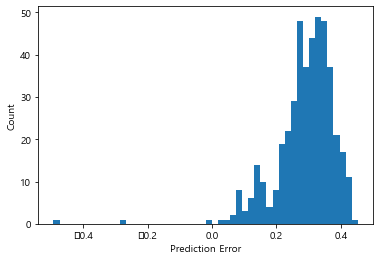

In [79]:
show_prediction_error(test_y, pred_xgb_1)

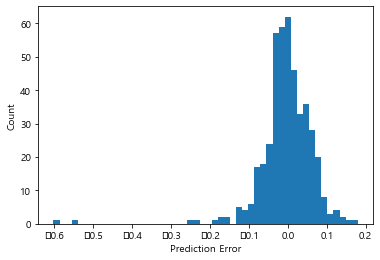

In [80]:
show_prediction_error(test_y, pred_xgb_2)

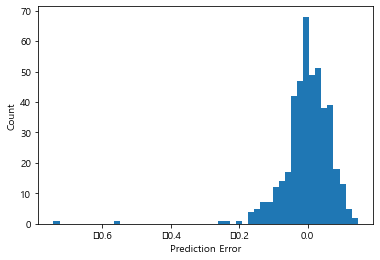

In [81]:
show_prediction_error(test_y, pred_lgbm)

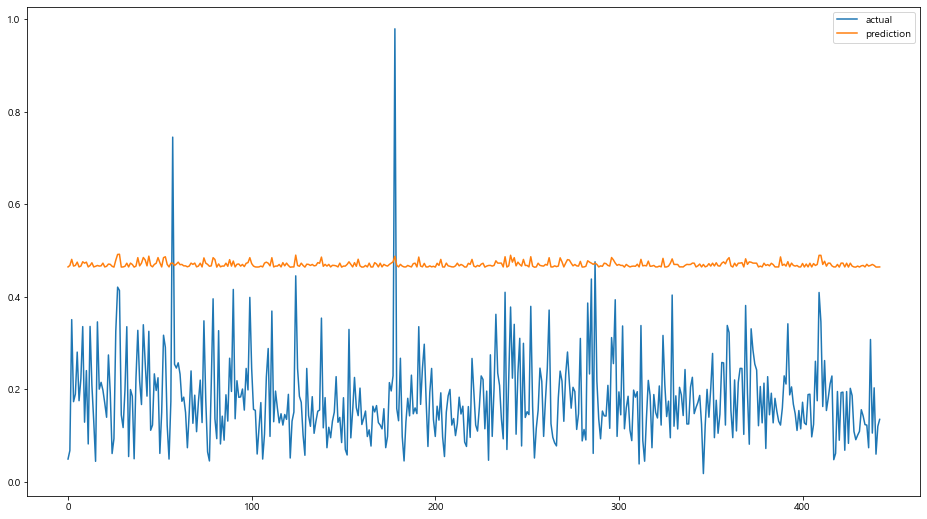

In [82]:
graph(pred_xgb_1, true_y)

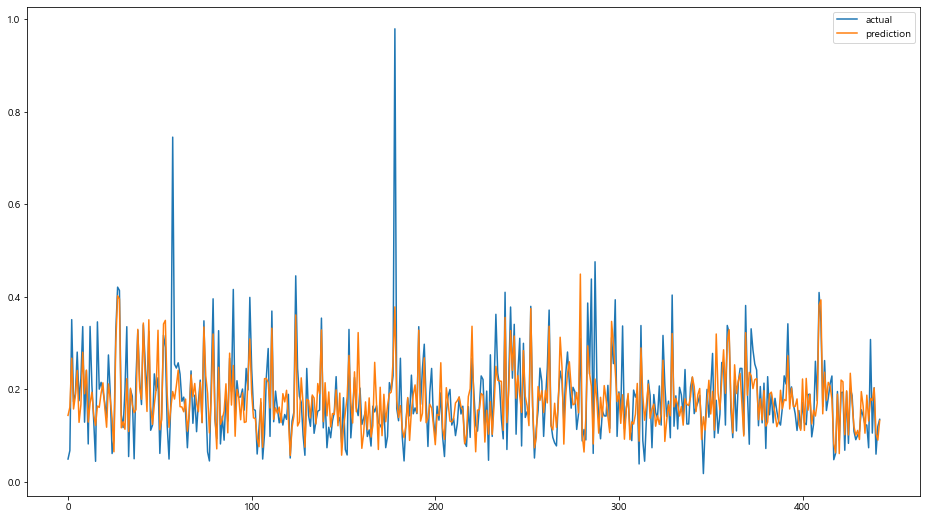

In [83]:
graph(pred_xgb_2, true_y)

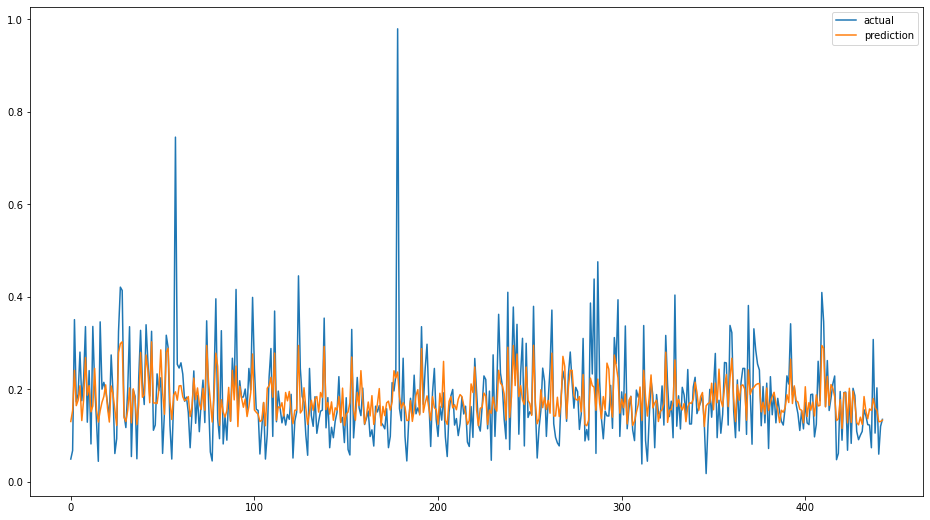

In [21]:
graph(pred_lgbm, true_y)

<AxesSubplot:>

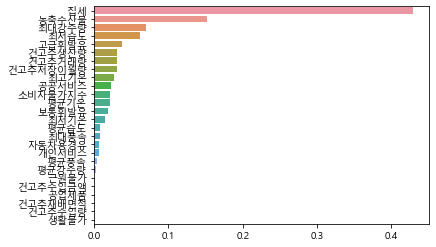

In [84]:
feature_series = pd.Series(data=model_xgb_1.feature_importances_, index=train_X.columns)
feature_series = feature_series.sort_values(ascending=False) 
sns.barplot(x = feature_series, y=feature_series.index)

In [85]:
feature_series = pd.Series(data=model_xgb_2.feature_importances_, index=train_X.columns)
feature_series = feature_series.sort_values(ascending=False) 
sns.barplot(x = feature_series, y=feature_series.index)

AttributeError: 'Booster' object has no attribute 'feature_importances_'

<AxesSubplot:>

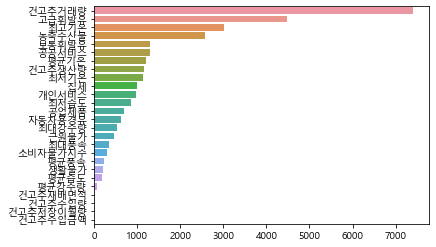

In [36]:
# 회귀 트리 Regressor 클래스는 선형 호귀와 다른 처리 방식이므로 회귀 계수를 제공하는 coef_ 속성이 없다. 
# 대신 feature_importances_를 이요해 피처별 중요도를 알 수 있다. 

feature_series = pd.Series(data=model_lgbm.feature_importances_, index=train_X.columns)
feature_series = feature_series.sort_values(ascending=False) 
sns.barplot(x = feature_series, y=feature_series.index)

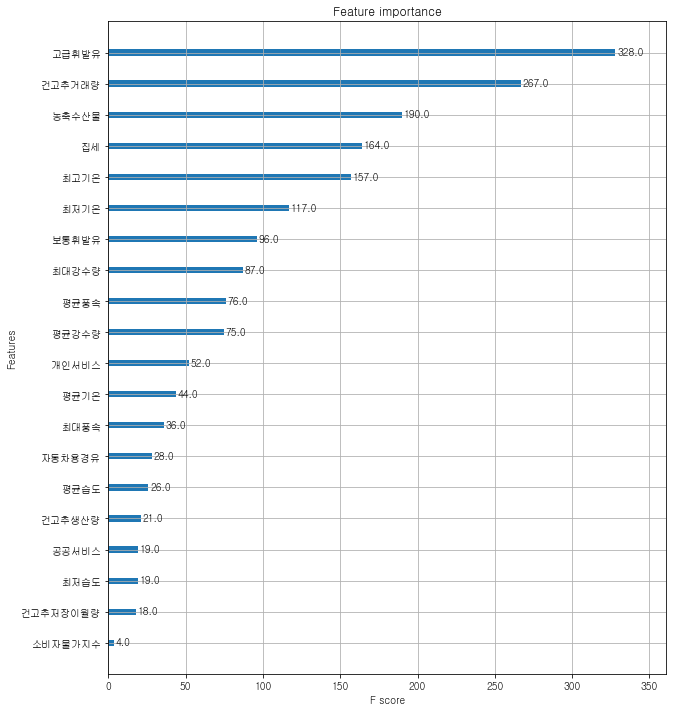

In [86]:
feature_importance(model_xgb_1)

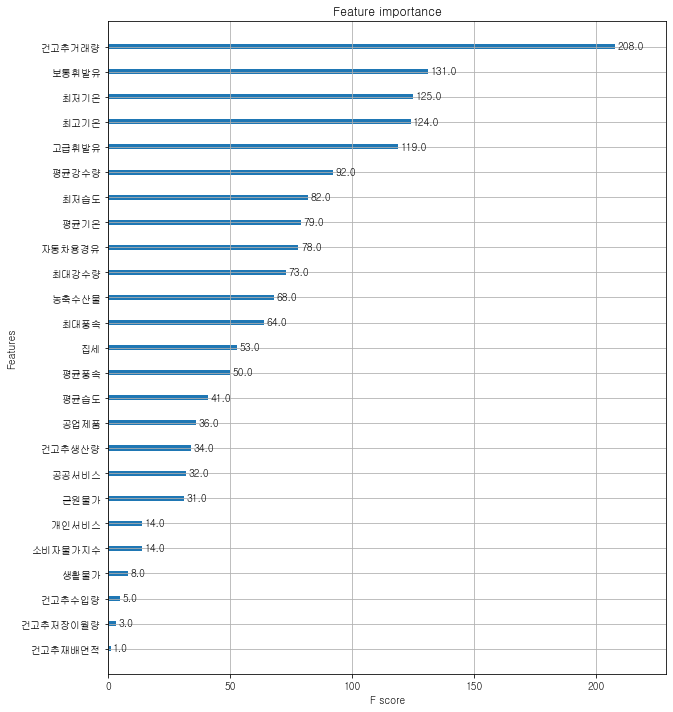

In [87]:
feature_importance(model_xgb_2)